In [2]:
#Load packages 
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import seaborn as sns

#https://drive.google.com/drive/folders/1As5waOdTXcExdtHAeYJ_eKThSOvTjUpa?fbclid=IwAR2J44akrinOKW36NBaeJBRbKgYs-fmh2s4yihHksM5bpi3btV6x72-9dtk

In [162]:
#Load json files
#sfo_census = gpd.read_file("san_francisco_censustracts.json")
sfo_taz= gpd.read_file("san_francisco_taz.json")

In [163]:
roads = gpd.GeoDataFrame.from_file("tl_2015_06_prisecroads.shp")

In [164]:
len(sfo_taz)

10451

In [3]:
#Load Uber data
#all_data= pd.read_csv("san_francisco-taz-2016-1-All-HourlyAggregate.csv")
#Load Uber data
all_data= pd.read_csv("san_francisco-taz-2017-3-All-HourlyAggregate.csv")

In [5]:
lengths = []
for hour in range(24):
    lengths.append(len(all_data[all_data['hod']==hour]))

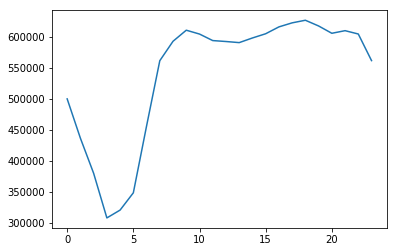

In [6]:
plt.plot(np.arange(24),lengths)

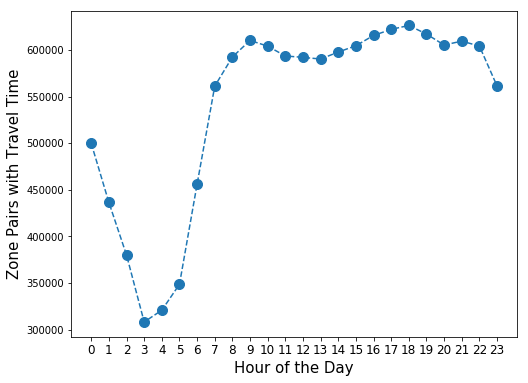

In [7]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(24),lengths,'o--',markersize=10)
plt.xticks(np.arange(0,24,1), fontsize=12)
plt.xlabel("Hour of the Day", fontsize=15)
plt.ylabel("Zone Pairs with Travel Time", fontsize=15)
#plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.savefig('LENGTH_SFO.pdf',bbox_inches='tight',dpi=1000)

In [46]:
x = np.arange(24)

print(x[lengths.index(max(lengths))])
print(x[lengths.index(min(lengths))])

18
3


In [166]:
sfo_taz.TZ06_D00_.values

array([    2,     3,     4, ..., 10450, 10451, 10452])

In [167]:
hour = 18
data= all_data[all_data['hod']==hour]


In [168]:
bay_area = ['097','055','095','013','001','085','081','075','041']

In [169]:
sfo_taz= sfo_taz[sfo_taz.COUNTY.isin(bay_area)]
#sfo_taz = sfo_taz[~sfo_taz.TZ06_D00_.isin([4612,3137])]

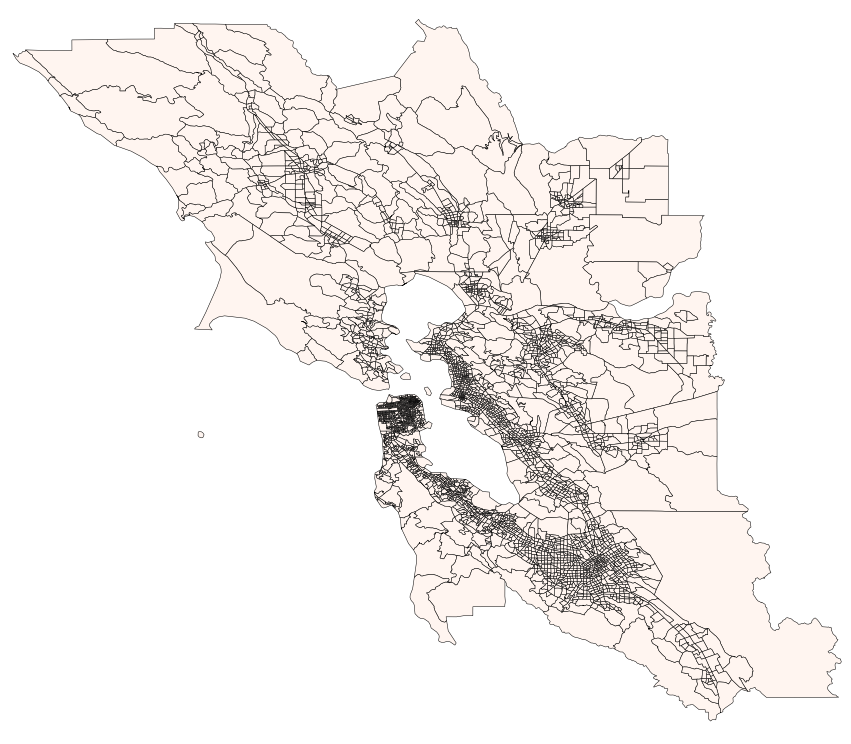

In [393]:

centroids = sfo_taz.centroid
sfo_taz['centroid'] = centroids
centroids.head()
#ax = sfo_taz.plot(figsize=(15,20),column='COUNTY',zorder=1,cmap='Set3')
sfo_taz['centroid'] =0
ax = sfo_taz.plot(figsize=(15,20),column='centroid',zorder=1,cmap='Reds',edgecolor='black',linewidth=0.5)
#centroids.plot(c='black',ax=ax, zorder=1,markersize=2)
west = -123.55 
east=-121.2
north = 38.9
south = 36.85
plt.xlim(-123.55,-121.2)
plt.ylim(36.85,38.9)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig("sfo_preprocess.pdf",bbox_inches='tight',dpi=1000)

In [171]:


#Load the same json files but save them on different variables
#census_ = json.loads(open('san_francisco_censustracts.json').read())
taz_ = json.loads(open('san_francisco_taz.json').read())

([], <a list of 0 Text yticklabel objects>)

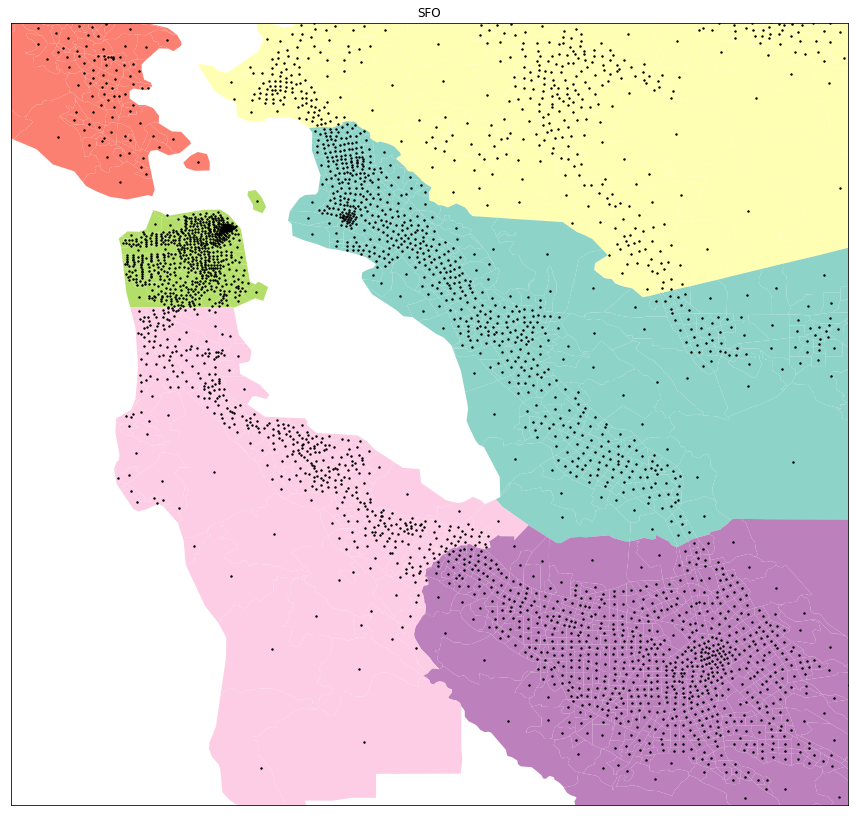

In [172]:
# west=-122.7578
# # south=37.2038
# # east=-121.7415
# # north=38.0002
margin=0.
west=-122.62868 +margin
south=37.181946 + margin
east=-121.744281+margin
north=38.008354 +margin

ax = sfo_taz.plot(figsize=(15,20),column='COUNTY',zorder=1,cmap='Set3')

#ADD CENTROIDS
centroids = sfo_taz.centroid
sfo_taz['centroid'] = centroids
centroids.head()
centroids.plot(c='black',ax=ax, zorder=1,markersize=2)


#edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="white")
plt.title("SFO") #date
plt.xlim(west,east)
plt.ylim(south,north)
plt.xticks([])
plt.yticks([])

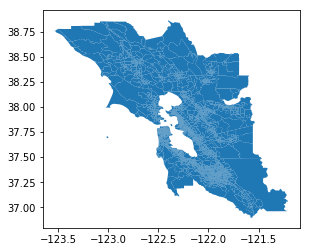

In [173]:
sfo_taz.plot()

In [174]:
sfo_taz.columns

Index(['AREA', 'PERIMETER', 'TZ06_D00_', 'TZ06_D00_I', 'STATE', 'COUNTY',
       'TAZ', 'NAME', 'LSAD', 'LSAD_TRANS', 'MOVEMENT_ID', 'DISPLAY_NAME',
       'geometry', 'centroid'],
      dtype='object')

In [175]:
zones_inside = sfo_taz.MOVEMENT_ID.values
#zones_inside[0]
new_features= []
count = 0
for i in range(len(taz_['features'])):
    if taz_['features'][i]['properties']['MOVEMENT_ID'] in zones_inside:
        new_features.append(taz_['features'][i])
taz_['features']=new_features

#Get features key of the dictionaries
#features_census = census_['features']
features_taz = taz_['features']
#print(len(features_census))
print(len(features_taz))

4073


In [176]:
#Get the places and the id's
#places_census=[x['properties']['DISPLAY_NAME'] for x in features_census]
#id_numbers_census=[int(x['properties']['MOVEMENT_ID']) for x in features_census]
places_taz=[x['properties']['DISPLAY_NAME'] for x in features_taz]
id_numbers_taz=[int(x['properties']['MOVEMENT_ID']) for x in features_taz]

county =[int(x['properties']['COUNTY']) for x in features_taz]

citiesfreq = {}
cities=[]
#Obtain frequency of cities/municipalities
for place in county: #in places_census or places_taz
    #place=[x.strip() for x in place.split(',')] #Take place string and split by comma
    cities.append(place) #Take last element of place because the format is "STREET,CITY"
    if place in citiesfreq.keys():
        citiesfreq[place]+=1
        #print(split_display[-1])
    else:
        citiesfreq[place]=1
        
##Get the descending list of places based on frequency 
import operator
citiesfreq = sorted(citiesfreq.items(), key=operator.itemgetter(1), reverse=True)
places = [x for x,y in citiesfreq] 
top10places = places[:10]

#idANDcity = [(x,y) for x,y in zip(id_numbers_census,cities)]
idANDcity = [(x,y) for x,y in zip(id_numbers_taz,cities)]

idANDcity = sorted(idANDcity, key=operator.itemgetter(0))

In [177]:
def getCentrality(hour,kind):
    data= all_data[all_data['hod']==hour]
    Score = []
    for i in id_numbers_taz:
        if kind.lower() == 'in':
            destinations = data[(data['dstid']==(i))] #INDEGREE
        elif kind.lower() =='out':
            destinations = data[(data['sourceid']==(i))] #OUTDEGREE
        #print(len(destinations))
        Score.append(len(destinations)) #get number of destinations from/to current origin 
    Score = np.array(Score)/(len(features_taz)-1) #NORMALIZE BY NUMBER OF ZONES AND ADD CENTRALITY VALUES AS COLUMN TO GEOJSON DATAFRAME
    Score = np.array(Score)
    
    #Create Centrality column
    sfo_taz['{}_Centrality'.format(kind)] = 0 
    for index, i in enumerate(id_numbers_taz):
        sfo_taz.loc[sfo_taz.MOVEMENT_ID == str(i),['{}_Centrality'.format(kind)]] = Score[index]
    print(len(sfo_taz))
    #add score to idANDcity array 
    idcityANDscore = [(x[0],x[1],y) for x,y in zip(idANDcity,Score)]
    return idcityANDscore   

In [427]:
def get_CCDF(kind):
    #Group zone data based on cities they belong to
    def CentralityProfile_2(results,city):
        zonesinCity = []

        for i in results:
            if i[1] == city:
                zonesinCity.append(i)
        zonesinCity = sorted(zonesinCity,key=operator.itemgetter(2),reverse=True)
        return zonesinCity
    citycentralities2 = []
    for i in places:
        if kind =='out':
            citycentralities2.append(CentralityProfile_2(out_results,i))
        elif kind=='in':
            citycentralities2.append(CentralityProfile_2(in_results,i))
            
    def CentralityProfile_BETTER(citycentralities):
        #Get maximum centrality per city
        maxes= []
        for i in citycentralities:
            maxes.append(max(i,key=operator.itemgetter(2))[2])

        #Make array containing id , city/town , centrality, and maximum centrality
        citycentralities = [(x,y) for x,y in zip(citycentralities,maxes)]

        #Sort based on decreasing maximum centrality
        citycentralities = sorted(citycentralities, key=operator.itemgetter(1),reverse=True)

        #Get original array of tuples without maxes
        citycentralities = [x for x,y in citycentralities]

        top10basedcentrality = [] # Top 10 based on centrality
        for i in citycentralities:
            top10basedcentrality.append(i[0][1]) #Get the city by getting the 2nd element (index 1) of the first element of each sub array.        
        #print(top10basedcentrality)
        #Make array containing centralities only
        centralityvalues = []
        for i in citycentralities:
            centralityvalues.append(
                [z for x,y,z in i])

        #Make array of 0 to 1 values for every set of centrality values for each city so that we can plot all of them together
        x = []
        for i in centralityvalues:
            zerotoone = [ t/(len(i)-1) for t in range(len(i))]
            x.append(zerotoone)

        xANDcentralities = []
        for i in range(len(centralityvalues)):
            xANDcentralities.append([(x,y) for x,y in zip(x[i],centralityvalues[i])])
        return xANDcentralities,top10basedcentrality     
    
    #Get how many zones in each Origin have data:
    zeroes = [0 for x in range(len(places))]
    counts = {key:value for key,value in zip(places,zeroes)}
    for city in citycentralities2:
        for x,y,z in city:
            if z!=0:
                counts[y]+=1
    counts = sorted(counts.items(),key=operator.itemgetter(1),reverse=True)

    top10places2 = [x for x,y in counts[:10]]
    #print(top10places2)
    #top10places2
    
    #Get cities only in top 10 based on number of origins that have data
    citycentralities2_new = []
    for i in citycentralities2:
        if i[0][1] in top10places2:
            citycentralities2_new.append(i)
    xANDcentralities2 = CentralityProfile_BETTER(citycentralities2_new)[0]
    top10basedcentrality2 = CentralityProfile_BETTER(citycentralities2_new)[1]
    xANDcentralities_median = []
    
    #SORT BASED ON MEDIAN
    for i in range(len(xANDcentralities2)):
        y = [y for x,y in xANDcentralities2[i]]
        median = np.median(y)
        new_array = [xANDcentralities2[i],median,top10basedcentrality2[i]]
        xANDcentralities_median.append(new_array)
    xANDcentralities_median = sorted(xANDcentralities_median, key=lambda x: x[1], reverse=True)
    orig_order = [z for x,y,z in xANDcentralities_median]
    print(orig_order)
    
    
    if hour == 3:
        if kind =='in':
            order =[75, 1, 85, 81, 13, 41, 55, 97, 95]
        elif kind=='out':
            order = [75, 85, 1, 13, 41, 81, 55, 95, 97]
    elif hour == 18:
        if kind=='in':
            order = [75, 1, 85, 81, 13, 41, 55, 97, 95]
        elif kind=='out':
            order =[75, 85, 1, 13, 41, 81, 55, 95, 97]
        
    new = []
    for num in order:
        for index,value in enumerate(xANDcentralities_median):
            #print(value[2])
            if value[2] == num:
                new.append(value)
    ccdf_data = new
    return ccdf_data

In [428]:

def ccdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n= len(data)

    # x-data for the CCDF: x
    x = np.sort(data)

    # y-data for the CCDF: y
    y = (1- (np.linspace(0, n, n) / n))*100 #multiply 100 to obtain percentage

    # y-data for ECDF: y
    #y = (np.arange(1, n+1) / n)
    return x, y
def county_label(countycode):
    county_codes = np.arange(1,116,2)

    county_labels = ['Alameda','Alpine','Amador','Butte','Calaveras','Colusa','Contra Costa','Del Norte','El Dorado','Fresno','Glenn','Humboldt','Imperial',\
              'Inyo','Kern','Kings','Lake','Lassen','Los Angeles','Madera','Marin','Mariposa','Mendocino','Merced','Modoc','Mono','Monterey','Napa',\
              'Nevada','Orange','Placer','Plumas','Riverside','Sacramento','San Benito','San Bernardino','San Diego','San Francisco',\
              'San Joaquin','San Luis Opispo','San Mateo','Santa Barbara','Santa Clara','Santa Cruz','Shasta','Sierra','Siksiyou','Solano','Sonoma',\
              'Stanislaus','Sutter','Tehama','Trinity','Tulare','Tuolamne','Ventura','Yolo','Yuba']
    return county_labels[np.where(county_codes == countycode)[0][0]] 

In [441]:
from matplotlib.ticker import StrMethodFormatter


def plot_CCDF(kind,hour):
    xANDcentralities_median = get_CCDF(kind)
    
    plt.figure(figsize=(8,6))

    plt.plot(np.linspace(0,1,100),[50 for i in range(100)],linestyle='--',color='black')
    if hour == 18:
        plt.plot([0.067 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
    elif hour == 3:
        if kind =='in':
            plt.plot([0.028 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
        elif kind=='out':
            plt.plot([0.034 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
    for i in range(len(xANDcentralities_median)):
        # Compute ECDF for versicolor data: x_vers, y_vers
        x_vers, y_vers = ccdf([y for x,y in xANDcentralities_median[i][0]])

        # Generate plot
        if county_label(xANDcentralities_median[i][2]) == 'San Francisco':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C0',label=county_label(xANDcentralities_median[i][2]))
        elif county_label(xANDcentralities_median[i][2]) == 'Santa Clara':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C1',label=county_label(xANDcentralities_median[i][2]))
        elif county_label(xANDcentralities_median[i][2]) == 'Alameda':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C2',label=county_label(xANDcentralities_median[i][2]))
        elif county_label(xANDcentralities_median[i][2]) == 'Contra Costa':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C3',label=county_label(xANDcentralities_median[i][2]))
        elif county_label(xANDcentralities_median[i][2]) == 'Marin':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C4',label=county_label(xANDcentralities_median[i][2]))
        elif county_label(xANDcentralities_median[i][2]) == 'San Mateo':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C5',label=county_label(xANDcentralities_median[i][2]))
        elif county_label(xANDcentralities_median[i][2]) == 'Napa':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C6',label=county_label(xANDcentralities_median[i][2]))
        elif county_label(xANDcentralities_median[i][2]) == 'Solano':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C7',label=county_label(xANDcentralities_median[i][2])) 
        elif county_label(xANDcentralities_median[i][2]) == 'Sonoma':
            plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,color='C8',label=county_label(xANDcentralities_median[i][2]))            
    #plt.plot(np.linspace(0,0.25,100),[14 for i in range(100)],linestyle='--',color='black')
    #plt.plot([0.1 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')

    # Make the margins nice
    plt.margins(0.01)

    # Label the axes
    
    if kind == 'in':
        plt.ylabel('CCDF($d^{in}$)',fontsize=15)
        plt.xlabel("Centrality ($d^{in}$)",fontsize=15)
    else:
        plt.ylabel('CCDF($d^{out}$)',fontsize=15)
        plt.xlabel("Centrality ($d^{out}$)",fontsize=15)
    plt.legend(fontsize=15)
    #set xtick and y tick fontsize
    plt.yticks(np.arange(0,101,5),fontsize=14)
    plt.xticks(np.linspace(0,0.30,5),fontsize=14)
    #plt.xticks(np.linspace(0,round(max(max(in_centralities),max(out_centralities)),2),5),fontsize=14)
    plt.ylim(-1,101)
    #plt.xlim(-0.001,max(max(in_centralities),max(out_centralities))+0.005)
    plt.xlim(-0.001,0.30)
    
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.savefig('{}_DEGREE_SFO_CCDF_hour_{}.pdf'.format(kind,hour),bbox_inches='tight',dpi=1000)

In [442]:
def percent_CCDF(kind,percent):   
    xANDcentralities_median = get_CCDF(kind)
    for i in range(len(xANDcentralities_median)):
        # Compute ECDF for versicolor data: x_vers, y_vers
        x_vers, y_vers = ccdf([y for x,y in xANDcentralities_median[i][0]])
        differences = []
        for index,value in enumerate(y_vers):
            differences.append(abs(percent-value))
        print("{}% of".format(percent), county_label(xANDcentralities_median[i][2]),"has at least a centrality value of :",round(x_vers[differences.index(min(differences))],3))

In [443]:
def cent_CCDF(kind,cent):
    xANDcentralities_median = get_CCDF(kind)
    target = cent
    for i in range(len(xANDcentralities_median)):
        x_vers, y_vers = ccdf([y for x,y in xANDcentralities_median[i][0]])
        differences = []
        for index,value in enumerate(x_vers):
            differences.append(abs(target-value))
        if max(x_vers)>=target:
            print(round(y_vers[differences.index(min(differences))],3),"% of", county_label(xANDcentralities_median[i][2]),"has at least a centrality value of",target)
        else:
            print(str(0),"% of", county_label(xANDcentralities_median[i][2]),"has at least a centrality value of",target)
        #print("Maximum centrality of city:",max(x_vers))

In [111]:
# # s_off_peak = gpd.read_file("centrality_SFO_hour_3_new.json")
# s_peak = gpd.read_file("centrality_SFO_hour_18_new.json")

In [418]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_map(zones_,kind,zoom=False,linewidth=0.0,set_bar=True,hour=3):    
    westlimit=-122.62868 
    southlimit=37.181946 
    eastlimit=-121.744281
    northlimit=38.008354
    
    if kind == 'in':
#         vmaxx = max(zones_.in_Centrality.values)
            vmaxx= 0.23
            print(max(zones_.in_Centrality.values))
    elif kind=='out':
#         vmaxx =max(zones_.out_Centrality.values)
            vmaxx = 0.23
            print(max(zones_.out_Centrality.values))
    if set_bar==True:
        vmin = 0
        vmax = 1
    elif set_bar == False:
        vmin = 0
        vmax = vmaxx
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    west = -123.55 
    east=-121.2
    north = 38.9
    south = 36.85
    ax = zones_.plot(figsize=(10,10),column='{}_Centrality'.format(kind),cmap='gist_heat_r',vmin=vmin, vmax=vmax,zorder=1,linewidth=linewidth,edgecolor='black')
    #plt.title(date) #date
    ax.axis('off')
    if zoom==False:
        plt.xlim(west,east)
        plt.ylim(south,north)
    else:
        #westlimit=-122.521907; southlimit=37.680985; eastlimit=-122.320377; northlimit=37.832718
        plt.xlim(westlimit,eastlimit)
        plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    #ADD ROADS LAYER
    roads.plot(ax=ax,color='cyan',alpha=0.35,edgecolor='black', linewidth=1,zorder=2)

    #PLACE COLORBAR
    fig = ax.get_figure()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.025)
    sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []

    cbar = fig.colorbar(sm, cax=cax)
    if zoom==False:
        plt.savefig("{}_centrality_map_SFO_hour_{}.pdf".format(kind,hour) ,bbox_inches='tight', dpi=1000)
        pass
    else:
        plt.savefig("{}_centrality_map_SFO_zoom_hour_{}.pdf".format(kind,hour),bbox_inches='tight', dpi=1000)
        pass
    plt.show()

0.2099705304518664


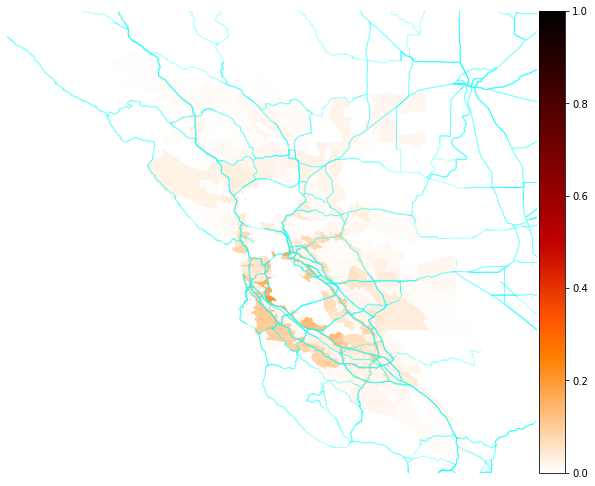

In [406]:
plot_map(s_peak,'in')

0.2099705304518664


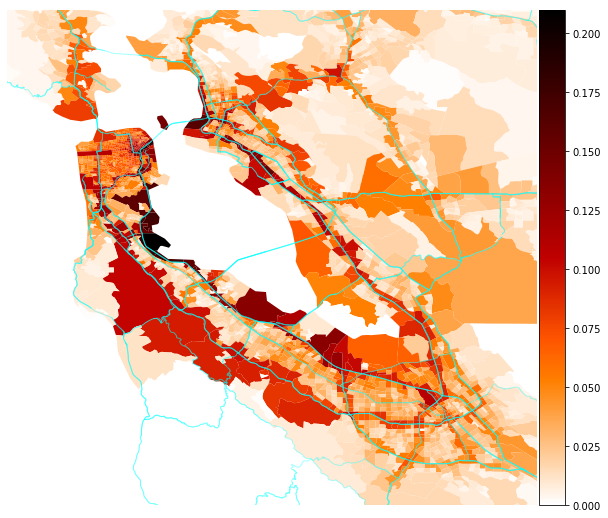

In [286]:
plot_map(s_peak,'in',True,0.0,False)

0.23256385068762278


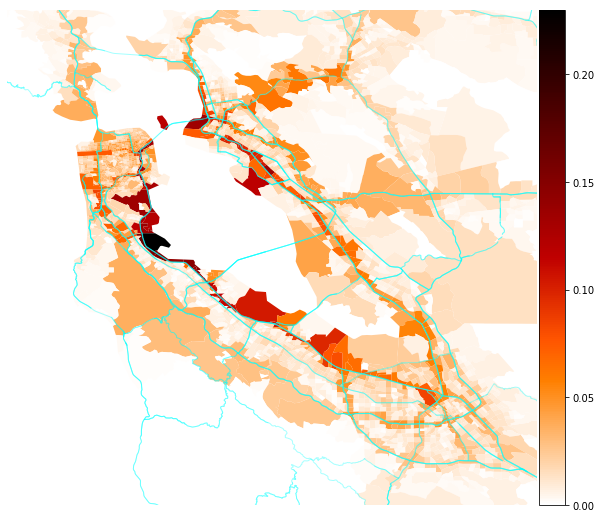

In [419]:
plot_map(hour3,'in',True,0.0,False,3)

0.14882121807465618


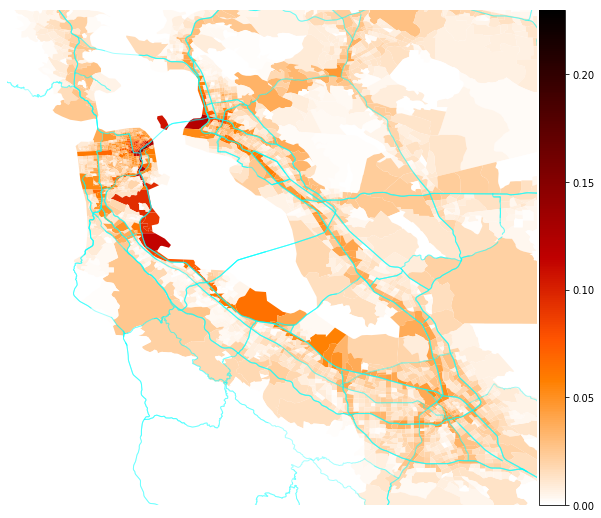

In [420]:
plot_map(hour3,'out',True,0.0,False,3)

0.2099705304518664


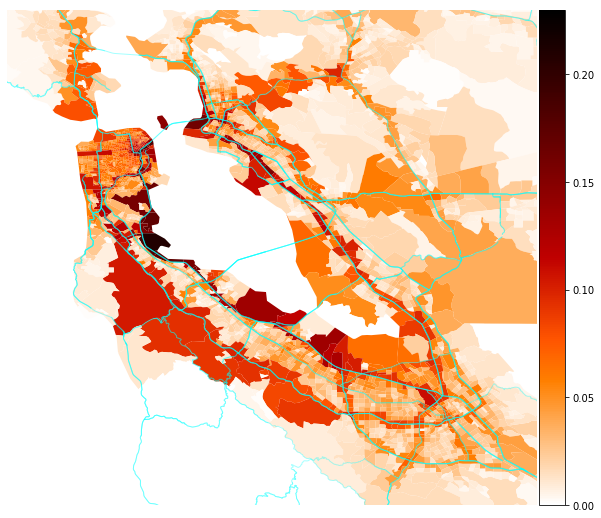

In [421]:
plot_map(hour18,'in',True,0.0,False,18)

0.21537328094302555


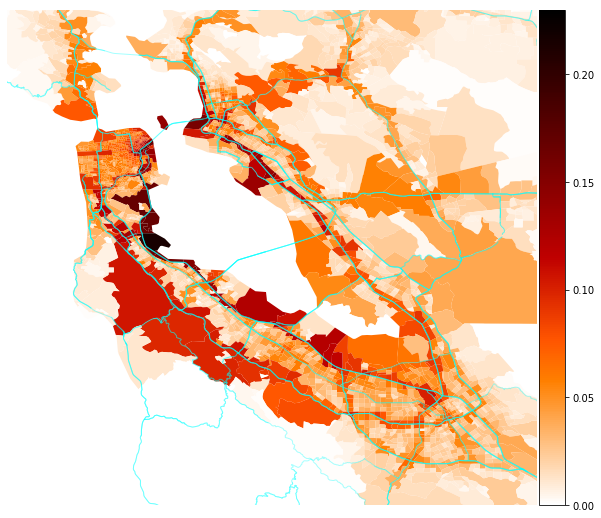

In [422]:
plot_map(hour18,'out',True,0.0,False,18)

0.23256385068762278


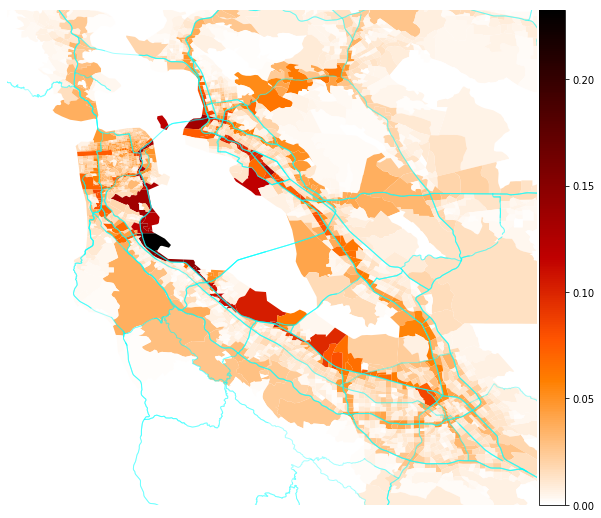

In [287]:
plot_map(hour3,'in',True,0.0,False)

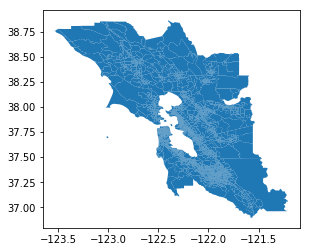

In [113]:
sfo_taz.plot()

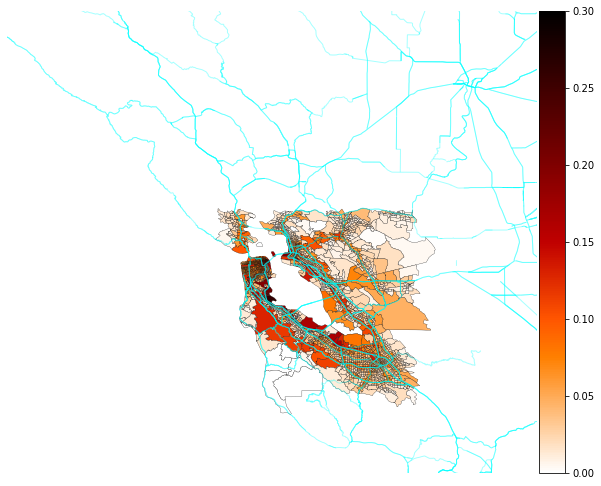

In [32]:
plot_map(s_peak,'in')

In [219]:
s_peak = gpd.read_file("centrality_SFO_hour_18_new.json")
s_off = gpd.read_file("centrality_SFO_hour_3_new.json")

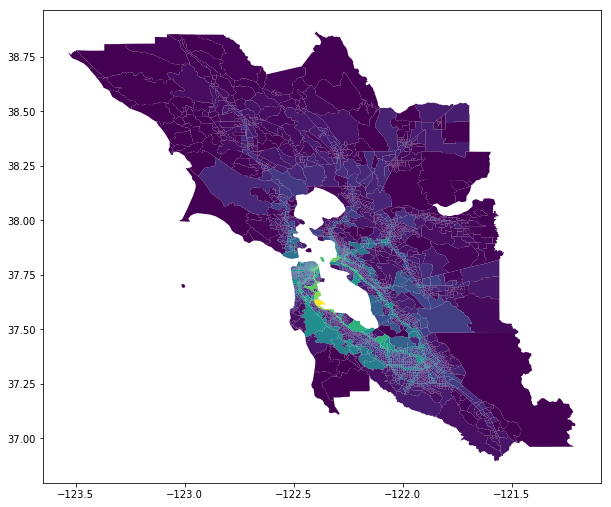

In [183]:
s_peak.plot(figsize=(10,10),column='in_Centrality')

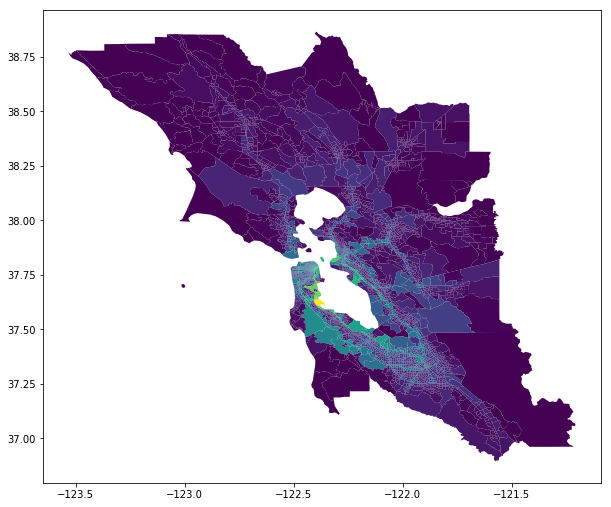

In [185]:
s_peak.plot(figsize=(10,10),column='out_Centrality')

In [220]:
s_peak['diff'] = s_peak.apply(lambda row: row.in_Centrality - row.out_Centrality, axis=1)
s_off['diff'] = s_off.apply(lambda row: row.in_Centrality - row.out_Centrality, axis=1)

In [222]:
def new_plots(testlang_,peak=True):
#     vmin = min(testlang_['diff'].values)
#     vmax= max(testlang_['diff'].values)
    if peak==True:
        vmin = -0.05
        vmax = 0.05
    else:
        vmin = -0.125
        vmax = 0.125
    ax = testlang_.plot(figsize=(10,10),column='diff',cmap='seismic',vmin=vmin,vmax=vmax)
    #metro_manila.plot(ax=ax,color='white',alpha=0.2,edgecolor='black', linewidth=1,zorder=3)

    #roads.plot(ax=ax,color='cyan',alpha=0.75,edgecolor='black', linewidth=0.5,zorder=2)
    #ADD ROADS LAYER
    #edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="blue")

    #plt.title('Metro Manila')
    #SET XLIM AND YLIM OF MAP
    #plt.title('Metro Manila Centrality Map [Hour: {}]'.format(hour),fontsize=20)
    #plt.xlim(120.9355,121.125)
    #plt.ylim(14.475,14.65)
    margin=0.
    west=-122.62868 +margin
    south=37.181946 + margin
    east=-121.744281+margin
    north=38.008354 +margin
    plt.xlim(west,east)
    plt.ylim(south,north)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    plt.xlim(west,east)
    plt.ylim(south,north)
    #PLACE COLORBAR
    fig = ax.get_figure()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []
    fig.colorbar(sm, cax=cax)

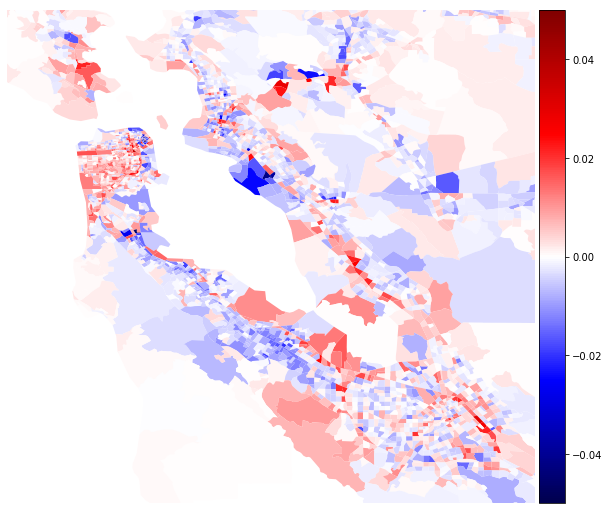

In [225]:
new_plots(s_peak,True)

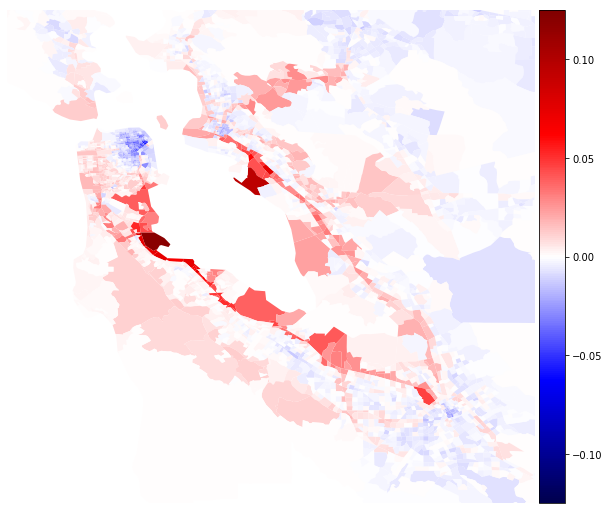

In [226]:
new_plots(s_off,False)

In [227]:
max(s_peak['diff'].values)

0.03610019646365423

In [114]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_map(tazz,kind,mini,zoom=False):    
    westlimit=-122.62868 
    southlimit=37.181946 
    eastlimit=-121.744281
    northlimit=38.008354
    #vmin, vmax = 0, max(out_centralities)+0.05
    vmin, vmax = 0, 0.3
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    west = -123.55 
    east=-121.2
    north = 38.9
    south = 36.85
    zones = tazz
    zones['categ'] = 0
    print(zones.columns)
    zones.loc[(zones['{}_Centrality'.format(kind)]>=round(mini,4)-0.005) & (zones['{}_Centrality'.format(kind)]<round(mini,4)) , 'categ'] = 1
    zones.loc[zones['{}_Centrality'.format(kind)]>=round(mini,4), 'categ'] = 2
    #zones.categ
    #ax = uber[(uber['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(8.5,8.5),color='red', vmin=vmin, vmax=vmax,zorder=2)
    ax = zones.plot(figsize=(15,15),column='categ',cmap='Set1_r',zorder=1,vmin=0,vmax=2)
    ax.axis('off')
    if zoom==False:
        plt.xlim(west,east)
        plt.ylim(south,north)
    else:
        #westlimit=-122.521907; southlimit=37.680985; eastlimit=-122.320377; northlimit=37.832718
        plt.xlim(westlimit,eastlimit)
        plt.ylim(southlimit,northlimit)
    plt.title(mini,fontsize=20)
    plt.xticks([])
    plt.yticks([])
    #ADD ROADS LAYER
    roads.plot(ax=ax,color='cyan',alpha=0.35,edgecolor='black', linewidth=1,zorder=2)

#     #PLACE COLORBAR
#     fig = ax.get_figure()
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.025)
#     sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     # fake up the array of the scalar mappable.
#     sm._A = []

   # cbar = fig.colorbar(sm, cax=cax)
    if zoom==False:
        #plt.savefig("{}_centrality_map_SFO_hour_{}.pdf".format(kind,hour) ,bbox_inches='tight', dpi=1000)
        pass
    else:
        #plt.savefig("{}_centrality_map_SFO_zoom_hour_{}.pdf".format(kind,hour), dpi=1000)
        pass
    plt.show()

Index(['AREA', 'PERIMETER', 'TZ06_D00_', 'TZ06_D00_I', 'STATE', 'COUNTY',
       'TAZ', 'NAME', 'LSAD', 'LSAD_TRANS', 'MOVEMENT_ID', 'DISPLAY_NAME',
       'geometry', 'centroid', 'in_Centrality', 'out_Centrality', 'categ'],
      dtype='object')


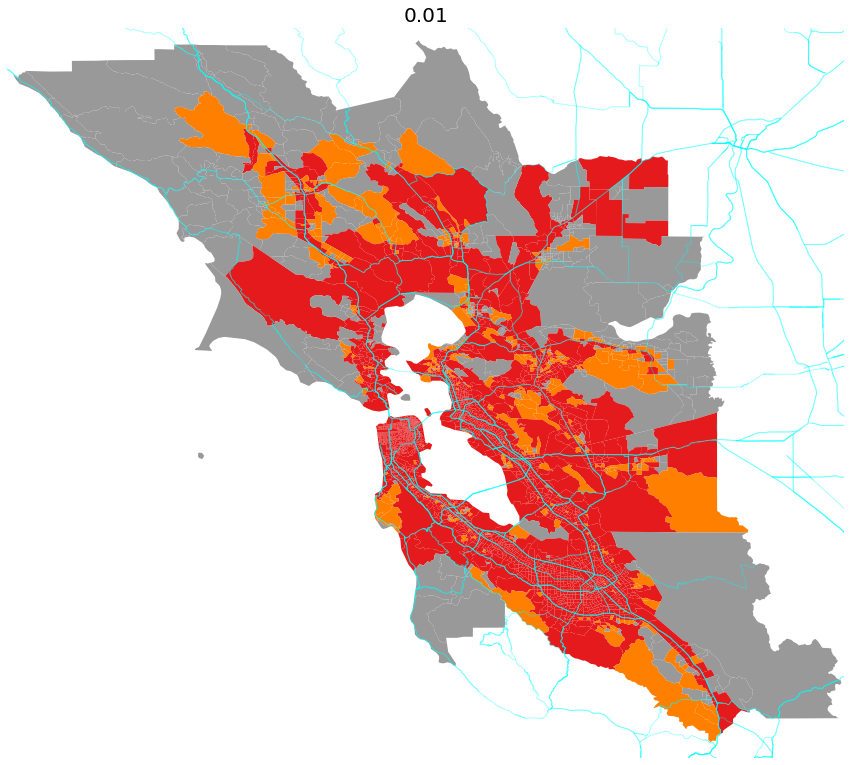

In [159]:
plot_map(sfo_taz,'in',0.010)

4073
4073
3 done


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


out
[75, 85, 1, 13, 41, 81, 55, 95, 97]
[75, 85, 1, 13, 41, 81, 55, 95, 97]
50% of San Francisco has at least a centrality value of : 0.034
50% of Santa Clara has at least a centrality value of : 0.015
50% of Alameda has at least a centrality value of : 0.014
50% of Contra Costa has at least a centrality value of : 0.009
50% of Marin has at least a centrality value of : 0.009
50% of San Mateo has at least a centrality value of : 0.008
50% of Napa has at least a centrality value of : 0.003
50% of Solano has at least a centrality value of : 0.002
50% of Sonoma has at least a centrality value of : 0.001
in
[75, 1, 85, 81, 13, 41, 55, 97, 95]
[75, 1, 85, 81, 13, 41, 55, 97, 95]
50% of San Francisco has at least a centrality value of : 0.028
50% of Alameda has at least a centrality value of : 0.013
50% of Santa Clara has at least a centrality value of : 0.012
50% of San Mateo has at least a centrality value of : 0.01
50% of Contra Costa has at least a centrality value of : 0.006
50% of Mari

/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


out
[75, 85, 1, 81, 41, 13, 55, 97, 95]
[75, 85, 1, 81, 41, 13, 55, 97, 95]
50% of San Francisco has at least a centrality value of : 0.067
50% of Santa Clara has at least a centrality value of : 0.032
50% of Alameda has at least a centrality value of : 0.031
50% of Contra Costa has at least a centrality value of : 0.013
50% of Marin has at least a centrality value of : 0.016
50% of San Mateo has at least a centrality value of : 0.029
50% of Napa has at least a centrality value of : 0.012
50% of Solano has at least a centrality value of : 0.004
50% of Sonoma has at least a centrality value of : 0.006
in
[75, 85, 1, 81, 41, 13, 55, 97, 95]
[75, 85, 1, 81, 41, 13, 55, 97, 95]
50% of San Francisco has at least a centrality value of : 0.066
50% of Alameda has at least a centrality value of : 0.028
50% of Santa Clara has at least a centrality value of : 0.031
50% of San Mateo has at least a centrality value of : 0.025
50% of Contra Costa has at least a centrality value of : 0.011
50% of Mar

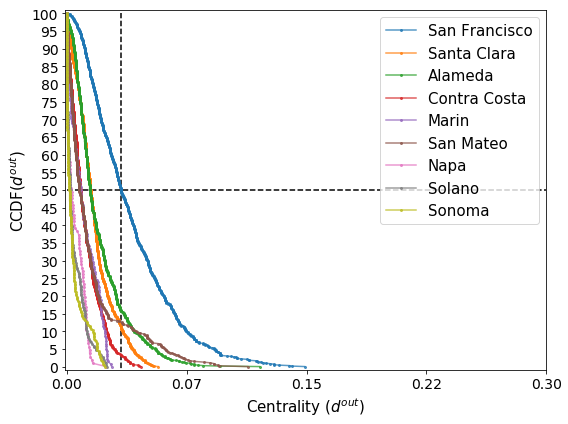

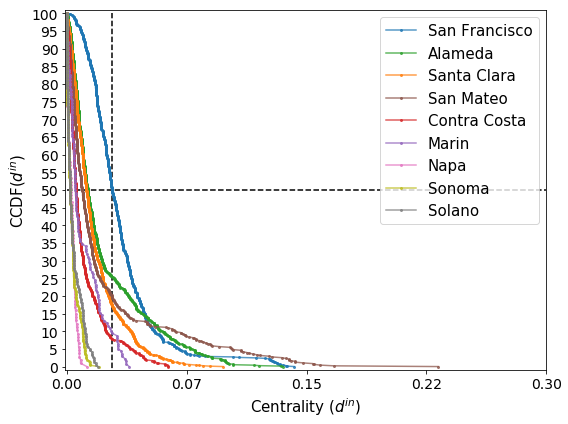

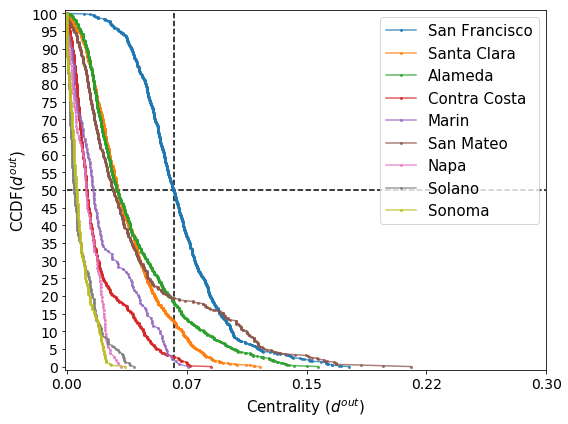

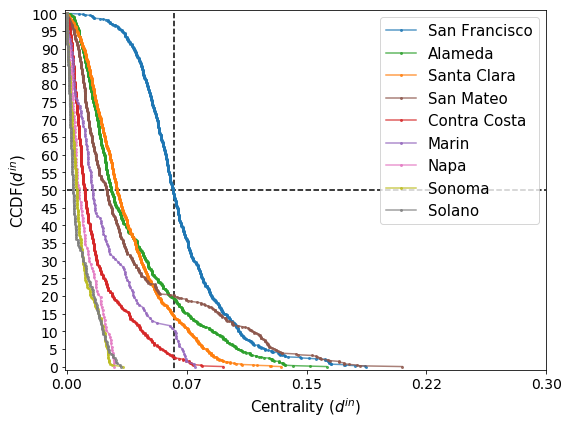

In [444]:
#for hour in [3,18]:
for hour in [3,18]:
    in_results= getCentrality(hour,'in')
    out_results = getCentrality(hour,'out')
    print(hour,"done")
    centrality_geojson= sfo_taz.drop('centroid', axis=1)
    centrality_geojson.to_file("centrality_SFO_hour_{}_new.json".format(hour), driver="GeoJSON")
    
    in_centralities = [z for x,y,z in in_results]
    out_centralities = [z for x,y,z in out_results]

#     plt.figure(figsize=(8,6))
#     plt.hist(in_centralities,alpha=0.8,histtype='step',bins=20,linewidth=2,label='In')
#     plt.hist(out_centralities,alpha=0.8,histtype='step',bins=20,linewidth=2,label='Out')
#     plt.ylabel('Frequency',fontsize=15)
#     plt.xlabel("Centrality ($d_{i}$)",fontsize=15)
#     plt.grid()
#     plt.legend(fontsize=15)

    print("out")
    plot_CCDF('out',hour)
    percent_CCDF('out',50)
    print('in')
    plot_CCDF('in',hour)
    percent_CCDF('in',50)
    
#     plot_map('out')
#     plot_map('in')

In [276]:
hour3 = gpd.read_file('centrality_SFO_hour_3_new.json')
hour8 = gpd.read_file('centrality_SFO_hour_8_new.json')
hour16 = gpd.read_file('centrality_SFO_hour_16_new.json')
hour17 = gpd.read_file('centrality_SFO_hour_17_new.json')
hour7= gpd.read_file('centrality_SFO_hour_7_new.json')
hour18= gpd.read_file('centrality_SFO_hour_18_new.json')

In [295]:
hour22= gpd.read_file('centrality_SFO_hour_22_new.json')

In [398]:
print(hour3.in_Centrality.values.max())
print(hour3.out_Centrality.values.max())
print(hour18.in_Centrality.values.max())
print(hour18.out_Centrality.values.max())

0.23256385068762278
0.14882121807465618
0.2099705304518664
0.21537328094302555


In [423]:
def get_diff(hour):
    vmin=-1
    vmax=1
    if hour == 8:
        hour_data = hour8
    elif hour == 7:
        hour_data = hour7
    elif hour == 17:
        hour_data = hour17
    elif hour == 16:
        hour_data = hour16
    elif hour== 22:
        hour_data = hour22
    elif hour ==3:
        hour_data = hour3
    elif hour ==18:
        hour_data = hour18
    hour_data['diff'] = hour_data.apply(lambda row: row.in_Centrality - row.out_Centrality, axis=1)
    print(max(hour_data['diff'].values),min(hour_data['diff'].values))
    vmin= -max([abs(max(hour_data['diff'].values)),abs(min(hour_data['diff'].values))])
    vmax= max([abs(max(hour_data['diff'].values)),abs(min(hour_data['diff'].values))])
    
    if hour == 3:
        vmin = -0.12
        vmax= 0.12
    elif hour == 18:
        vmin = -0.12
        vmax = 0.12
    elif hour == 7:
        vmin = -0.08
        vmax = 0.08
    elif hour == 17:
        vmin = -0.08
        vmax = 0.08
    ax = hour_data.plot(figsize=(10,10),column='diff',cmap='seismic',vmin=vmin,vmax=vmax)

    margin=0.
    west=-122.62868 +margin
    south=37.181946 + margin
    east=-121.744281+margin
    north=38.008354 +margin
    plt.xlim(west,east)
    plt.ylim(south,north)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

    plt.xlim(west,east)
    plt.ylim(south,north)
    #PLACE COLORBAR
    fig = ax.get_figure()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    plt.savefig("net_usage_sfo_{}.pdf".format(hour) ,bbox_inches='tight', dpi=1000)

0.11935166994106089 -0.06065815324165029


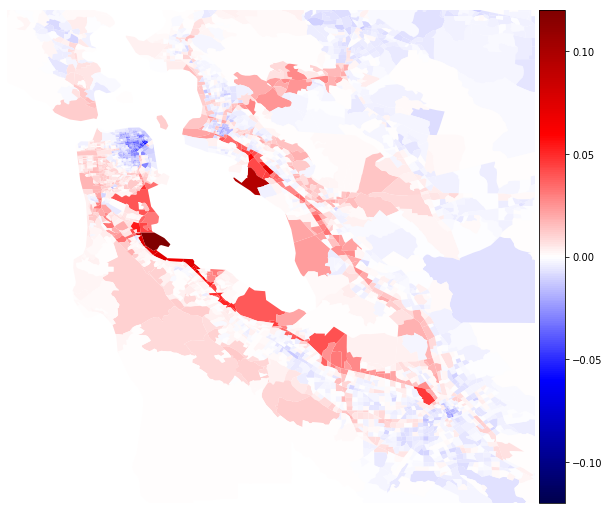

In [424]:
get_diff(3)

0.03610019646365423 -0.05402750491159135


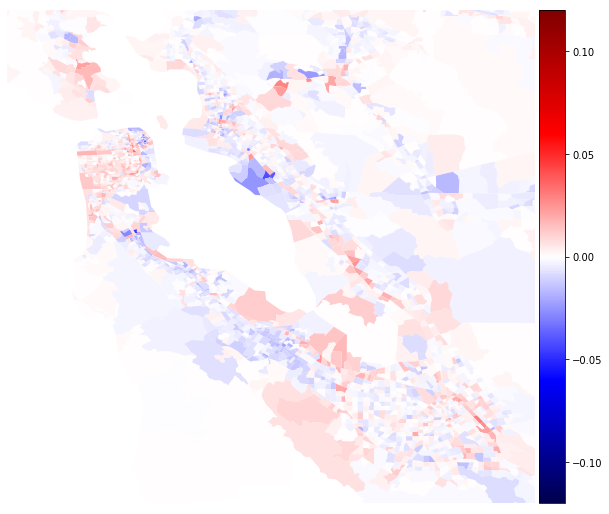

In [425]:
get_diff(18)

0.06335952848722987 -0.038310412573673874


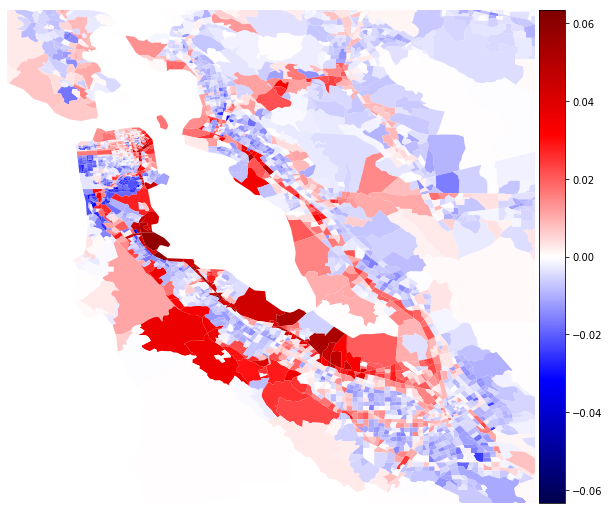

In [309]:
get_diff(8)

0.08668958742632613 -0.038310412573673874


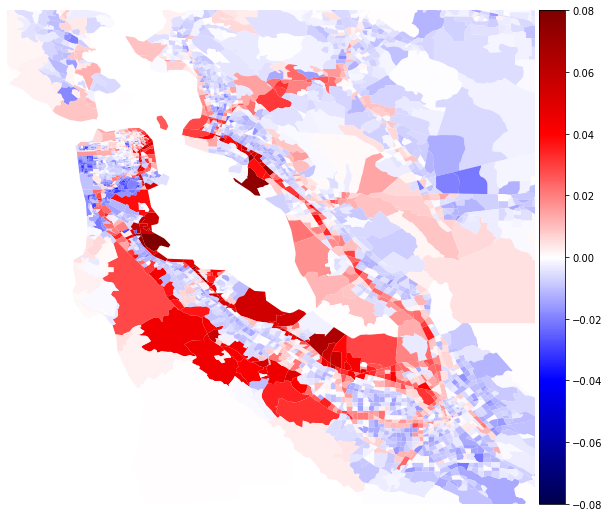

In [322]:
get_diff(7)

0.03831041257367389 -0.050834970530451856


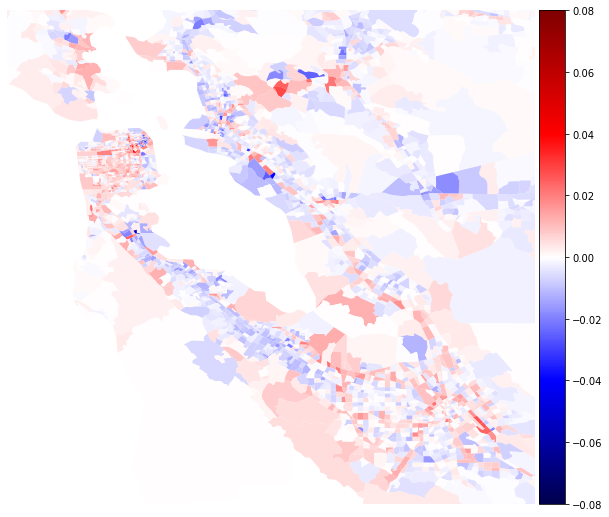

In [323]:
get_diff(17)

0.037573673870334 -0.05009823182711198


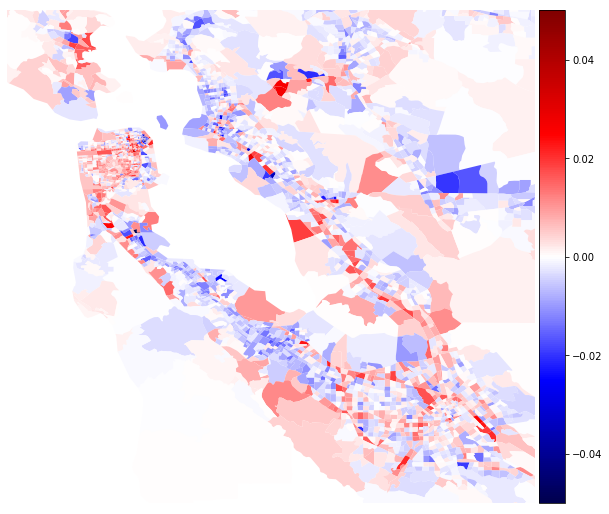

In [302]:
get_diff(16)

0.04101178781925344 -0.07784872298624755


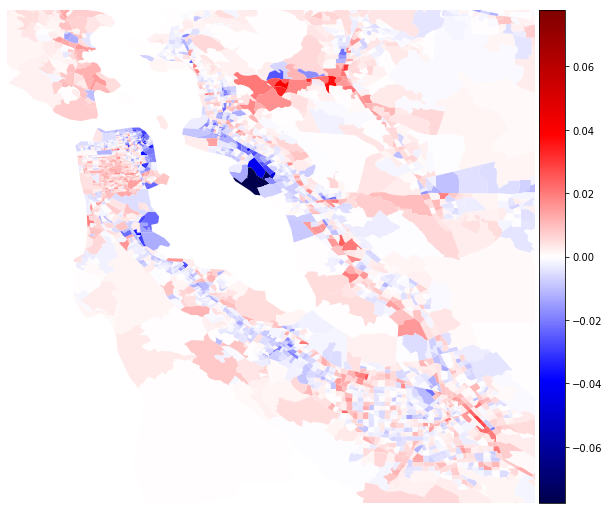

In [303]:
get_diff(22)

## Centrality maps plot

0.23256385068762278


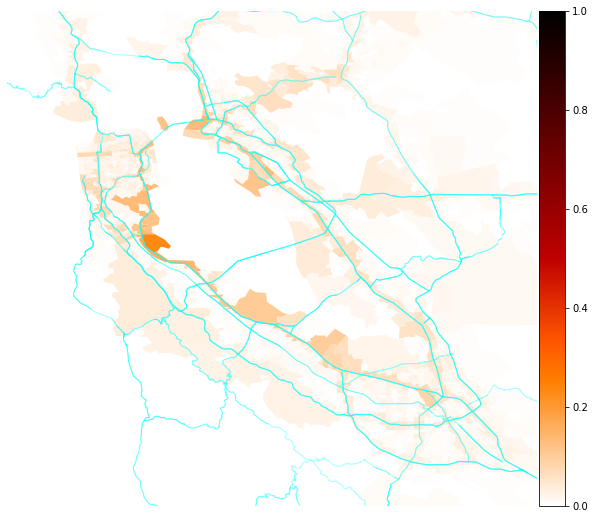

In [294]:
plot_map(hour3,'in',True,0.0,True)

In [280]:
def city_ccdf(hour,kind):
    if hour == 8:
        hour_data = hour8
    elif hour == 7:
        hour_data = hour7
    elif hour == 17:
        hour_data = hour17
    elif hour == 16:
        hour_data = hour16
    elif hour == 3:
        hour_data = hour3
    if kind =='in':
        x,y = ccdf(hour_data.in_Centrality.values)
    else:
        x,y = ccdf(hour_data.out_Centrality.values)
        
    plt.figure(figsize=(8,6))

    plt.plot(x,y,marker='o',linestyle='-',markersize=2,alpha=0.75)
    plt.ylabel('CCDF ($d^{in}$)',fontsize=15)
    if kind == 'in':
        plt.xlabel("Centrality ($d^{in}$)",fontsize=15)
    else:
        plt.xlabel("Centrality ($d^{out}$)",fontsize=15)
    #plt.legend(fontsize=15)
    #set xtick and y tick fontsize
    plt.yticks(np.arange(0,101,5),fontsize=14)
    plt.xticks(np.linspace(0,1,5),fontsize=14)
    #plt.xticks(np.linspace(0,round(max(max(in_centralities),max(out_centralities)),2),5),fontsize=14)
    plt.ylim(-1,101)
    #plt.xlim(-0.001,max(max(in_centralities),max(out_centralities))+0.005)
    plt.xlim(-0.001,1)

    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

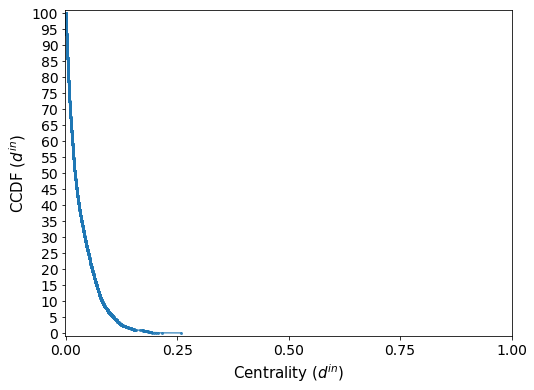

In [281]:
city_ccdf(7,'in')

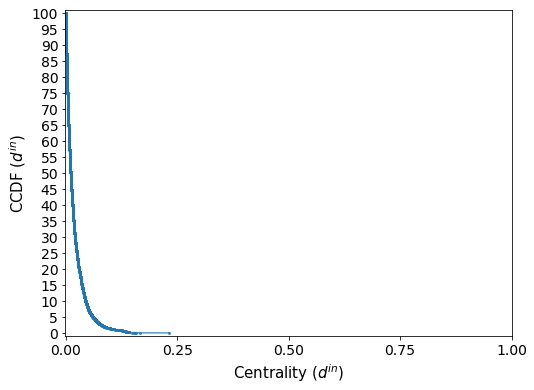

In [282]:
city_ccdf(3,'in')

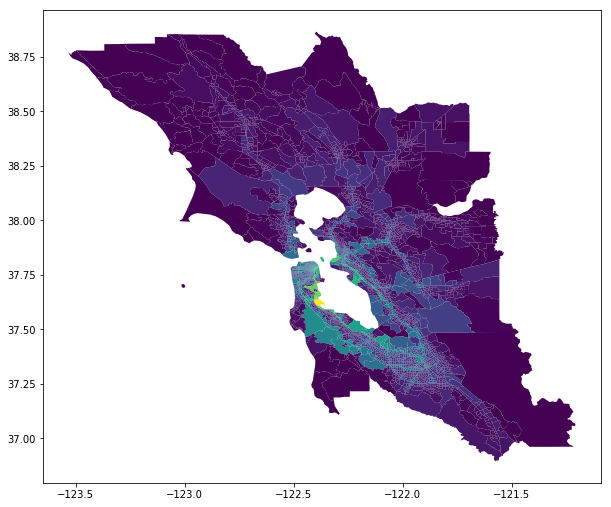

In [129]:
centrality_geojson.plot(figsize=(10,10),column='out_Centrality')

In [133]:
s_off_peak = gpd.read_file("centrality_SFO_hour_3.json")
s_peak = gpd.read_file("centrality_SFO_hour_18.json")

In [134]:
len(s_peak)

3279

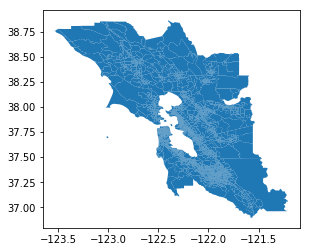

In [136]:
sfo_taz.plot()

### RESOURCE ALLOCATION PREP

In [384]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plotter(mini,kind,hour):
    vmin, vmax = 0, 1
    if hour==18:
        hour_data = hour18
    elif hour==3:
        hour_data = hour3
#         zones = s_peak
#     else:
#         zones= s_off_peak
    #zones = sfo_taz
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    west = -123.55 
    east=-121.2
    north = 38.9
    south = 36.85
    #ax = sfo_taz[(sfo_taz['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),column='{}_Centrality'.format(kind),cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    #plt.title("Centralities greater than "+ str(round(mini,1))) #date
    ax = hour_data[(hour_data['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),color='red')
    #print(hour_data['{}_Centrality'.format(kind)].values.max())
    #ax = zones[(zones['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),color='red')
    ax.axis('off')
    #plt.xlim(west,east)
    #plt.ylim(south,north)
    westlimit=-123.741; southlimit=36.8442; eastlimit=-121.1867; northlimit=38.8951
    plt.xlim(west,east)
    plt.ylim(south,north)
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig('{}_centrality_from_greater_than_{}_hour_{}.png'.format(kind,round(mini,4),hour), format='png', dpi=300)
    #plt.savefig('TEST.png')
    plt.close()
    #print(len(zones))


In [385]:
plotter(0.12,'out',18)

In [386]:
plotter(0.12,'out',3)

In [387]:
plotter(0.12,'in',3)

In [388]:
plotter(0.12,'in',18)

In [356]:
cents = np.arange(0,0.240,0.005)
for hour in [3,18]:
    print(hour)
    #in_results= getCentrality(hour,'in')
    #out_results = getCentrality(hour,'out')
    for kind in ['out','in']:
        print(kind)
        for mini in cents:
            print(mini)
            plotter(mini,kind,hour)

3
out
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.155


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.16


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.165


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.17


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.17500000000000002


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.18


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.185


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.19


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.195


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.2


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.20500000000000002


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.21


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.215


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.22


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.225


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.23


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.23500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


in
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21
0.215
0.22
0.225
0.23
0.23500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


18
out
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21
0.215
0.22


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.225


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.23


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.23500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


in
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.215


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.22


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.225


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.23


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.23500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


In [ ]:
plotter(0,'in',18)

In [64]:
len(m_peak)

3279

### RESOURCE ALLOCATION HIGHLIGHT

In [73]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plotter(kind,mini,hour):
    vmin, vmax = 0, 1
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    if hour==18:
        zones = s_peak
    else:
        zones= s_off_peak
    zones['categ'] = 0
    print(zones.columns)
    zones.loc[(zones['{}_Centrality'.format(kind)]>=round(mini,4)) , 'categ'] = 1
    #zones.loc[zones['{}_Centrality'.format(kind)]>=round(mini,4), 'categ'] = 2
    #zones.categ
    #ax = uber[(uber['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(8.5,8.5),color='red', vmin=vmin, vmax=vmax,zorder=2)
    ax = zones.plot(figsize=(8.5,8.5),column='categ',cmap='Set1_r',zorder=1,vmin=0,vmax=1)
    ax.axis('off')
    #plt.xlim(west,east)
    #plt.ylim(south,north)
    
     #ADD ROADS LAYER
    #roads.plot(ax=ax,color='cyan',alpha=0.75,edgecolor='black', linewidth=0.5,zorder=2)
    west = -123.55 
    east=-121.2
    north = 38.9
    south = 36.85
    plt.xlim(west,east)
    plt.ylim(south,north)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    #plt.savefig('{}_centrality_from_greater_than_{}_hour_{}.png'.format(kind,round(mini,4),hour), format='png', dpi=300)
    #plt.savefig('TEST.png')
    #plt.close()
    
# cents = np.arange(0,1.005,0.01)
# for hour in [3,18]:
#     print(hour)
#     in_results= getCentrality(hour,'in')
#     out_results = getCentrality(hour,'out')
#     for kind in ['in','out']:
#         print(kind)
#         for mini in cents:
#             print(mini)
#             plotter(mini,kind,hour)

Index(['AREA', 'PERIMETER', 'TZ06_D00_', 'TZ06_D00_I', 'STATE', 'COUNTY',
       'TAZ', 'NAME', 'LSAD', 'LSAD_TRANS', 'MOVEMENT_ID', 'DISPLAY_NAME',
       'in_Centrality', 'geometry', 'categ'],
      dtype='object')


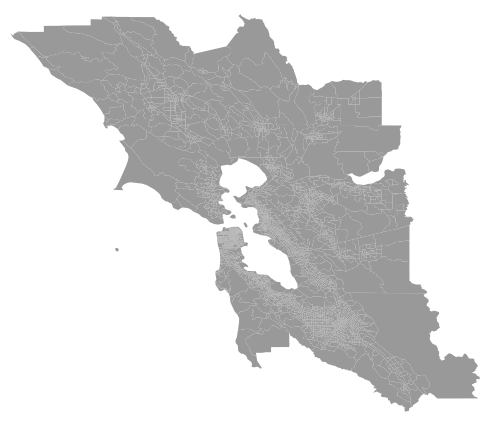

In [74]:
plotter('in',0.5,18)

In [17]:
    
cents = np.arange(0,1.005,0.005)

### RESOURCE ALLOCATION : total land area and greatest cluster area measurement thru HK algorithm implementation

In [357]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [358]:
%%cython

import numpy as np
cimport numpy as np
import time
cimport cython

DTYPE = np.uint32
ctypedef np.uint32_t DTYPE_t

def latticegen(int N, float p):
    cdef np.ndarray[DTYPE_t, ndim=2] lattice
    lattice = np.ones([N,N], dtype=DTYPE)*(np.random.random([N,N])<p)
    return lattice

cdef int find(int x, labellist):
    while labellist[x] != x:
        x = labellist[x]
    return x
    
cdef int union(int a, int b, labellist):
    cdef int above, left
    above = find(b, labellist)
    left = find(a, labellist)
    labellist[above] = left
    return left

def percolate(int N, int p, np.ndarray[DTYPE_t, ndim=2] labels, labellist):
    cdef int left, above, x, y
    cdef int largest_label = 0
    for x from 0<= x < N:
        for y from 0<= y < N:
            if labels[y,x]:
                if x!=0: left = labels[y, x-1]
                else: left = 0
                if y!=0: above = labels[y-1, x]
                else: above = 0
                if left == 0 and above == 0:
                    largest_label += 1
                    labellist.append(largest_label)
                    labels[y,x] = largest_label
                else:
                    if left != 0:
                        if above != 0:
                            labels[y,x] = union(left, above, labellist)
                        labels[y,x] = find(left, labellist)
                    else:
                        labels[y,x] = find(above, labellist)
    coll = collapse(N, labels, labellist)
    return coll
    
def collapse(int N, np.ndarray[DTYPE_t, ndim=2] labels, labellist):
    cdef int x, y
    newlist = [find(i, labellist) for i in range(len(labellist))]
    for x from 0<= x < N:
        for y from 0<= y < N:
            if labels[y,x]:
                labels[y,x] = newlist[labels[y,x]]
    return labels

    
def main(int N, float p):#, np.ndarray[DTYPE_t, ndim=2] labels):
    labels = latticegen(N,p)
    labellist = [0]
    s = percolate(N, p, labels, labellist)
    return s


In [359]:
def do_perc(image):
    labellist=[0]
    shape = image.shape[0]

    M = percolate(shape,0,image.astype(np.uint32),labellist)
    ## REDUCE LABELS 
    unique, counts = np.unique(M, return_counts=True)
    #print(unique,counts)
    for index,value in enumerate(unique):
        #print(index)
        M[M==value] =index
    if len(unique)>1:
        CLUSTER_SIZE = counts[unique!=0][counts[unique!=0] == counts[unique!=0].max()][0] #FIND  MAX FREQUENCY OF NON-ZERO CLUSTER
        TOTAL = sum(counts[unique!=0])
        NUM_CLUSTERS = len(unique)-1
    else:
        CLUSTER_SIZE =0
        TOTAL = 0
        NUM_CLUSTERS = 0 
    #plt.figure(figsize=(10,10))
    #plt.imshow(M)
    #plt.axis('off')
    #plt.colorbar()
    
    #return unique,counts
    
    return NUM_CLUSTERS,CLUSTER_SIZE, TOTAL #Do not consider cluster of 0 values as a cluster

In [360]:
def load_binary(kind,cent,hour):
    img = plt.imread('{}_centrality_from_greater_than_{}_hour_{}.png'.format(kind,cent,hour))[:,:,1]
    #img = plt.imread('centrality_from_0.7_to_0.8.png')[:,:,1]/255.

    unique, counts = np.unique(img.flatten(),return_counts=True)

    copy = img<unique[-1].astype(int)
    plt.imshow(copy)
    return copy

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

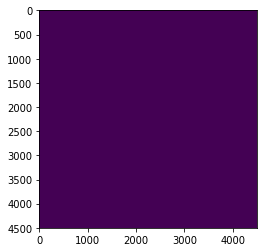

In [362]:
load_binary('out',0.15,3)

In [60]:
num_cluster,size, total= do_perc(load_binary('in',round(0.05,4),18))
print(num_cluster,size, total)

3 2490915 2605855


### Run TLA and LCA measurement

In [77]:
cents = np.arange(0,0.240,0.005)

0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195

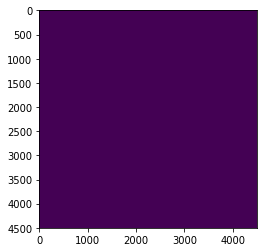

In [363]:
for hour in [3,18]:
    for kind in ['in','out']:    
        num_clusters= []
        cluster_sizes=[]
        total_sizes= []
        for i in cents:
            print(round(i,4))
            num_cluster,size,total= do_perc(load_binary(kind,round(i,4),hour))
            num_clusters.append(num_cluster)
            cluster_sizes.append(size)
            total_sizes.append(total)
        a = list(zip(cents,cluster_sizes,num_clusters,total_sizes))
        with open('{}_cluster_analysis_SFO_hour_{}.txt'.format(kind,hour),'w') as f:
            for i in a:
                f.write(str(i)+'\n')

In [9]:
print("a")

a


In [366]:
hour = 18
kind ='out'
with open('{}_cluster_analysis_SFO_hour_{}.txt'.format(kind,hour)) as f:
    for line in f:
        line = line.replace(',','')
        values = line[1:-2].split()
        print(values[3])

4187843
2008432
1639959
1206624
957329
690233
576634
515140
438097
336572
303067
269021
232488
209154
186997
169499
146889
129676
118482
106839
76078
71511
41421
37731
32419
21356
19896
18039
13663
12558
12437
11261
9657
8490
2701
2488
2415
2339
2339
2339
2106
2106
2106
2106
0
0
0
0


7805180.0
7805180.0
7805180.0
7805180.0


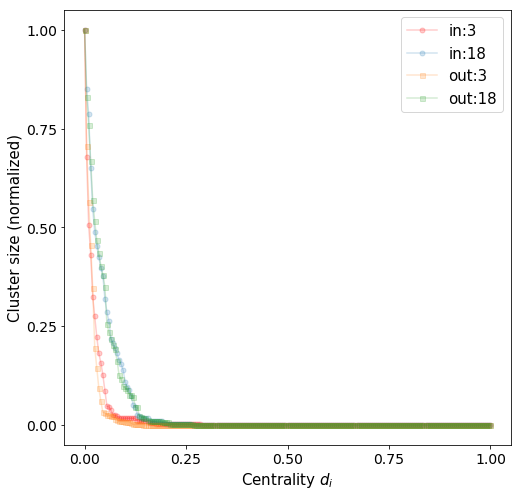

In [195]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8,8))
for kind in ['in','out']:
    for hour in [3,18]:
        cents = []
        cluster_sizes = []
        num_clusters=[]
        total_sizes= []
        with open('{}_cluster_analysis_SFO_hour_{}.txt'.format(kind,hour)) as f:
            for line in f:
                line = line.replace(',','')
                values = line[1:-2].split()

                cents.append(float(values[0]))
                cluster_sizes.append(float(values[1]))
                num_clusters.append(float(values[2]))
                total_sizes.append(float(values[3]))
                #print(values[2])

        print(cluster_sizes[0])
    
        if hour ==3:
            if kind=='in':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes),'o-',  color='r',markersize= 5,alpha=0.2,label=kind+":"+str(hour))
                #plt.plot(cents, np.array(total_sizes)/max(total_sizes),'o-',  color='r',markersize= 5,alpha=0.2,label=kind+":"+str(hour))
            elif kind=='out':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes), 's-',markersize= 5,alpha=0.2,label=kind+":"+str(hour))
        elif hour ==18:
            if kind=='in':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes), 'o-',markersize=5,alpha=0.2,label=kind+":"+str(hour))
            elif kind=='out':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes), 's-',markersize= 5,alpha=0.2,label=kind+":"+str(hour))
plt.title("")
plt.xlabel("Centrality $d_{i}$",fontsize=15)
plt.ylabel("Cluster size (normalized)",fontsize=15)

plt.yticks(np.linspace(0,1,5),fontsize=14)
plt.xticks(np.linspace(0,1,5),fontsize=14)
plt.legend(fontsize=15)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.savefig('SFO_CLUSTER.pdf'.format(kind,hour),bbox_inches='tight',dpi=1000)


In [150]:
off_peak = gpd.read_file("centrality_SFO_hour_3.json")
peak = gpd.read_file("centrality_SFO_hour_18.json")

In [151]:
off_peak[off_peak['in_Centrality'] == off_peak['in_Centrality'].max()]

AREA  PERIMETER  TZ06_D00_  TZ06_D00_I STATE COUNTY     TAZ    NAME  \
1966  0.000899   0.131536       5137        5138    06    081  201659  201659   

     LSAD LSAD_TRANS MOVEMENT_ID   DISPLAY_NAME  in_Centrality  \
1966                        5135  201659 (5135)       0.288896   

      out_Centrality                                           geometry  
1966        0.140635  POLYGON ((-122.3817095887884 37.63523876751263...

In [152]:
peak[peak['in_Centrality'] == peak['in_Centrality'].max()]

AREA  PERIMETER  TZ06_D00_  TZ06_D00_I STATE COUNTY     TAZ    NAME  \
1966  0.000899   0.131536       5137        5138    06    081  201659  201659   

     LSAD LSAD_TRANS MOVEMENT_ID   DISPLAY_NAME  in_Centrality  \
1966                        5135  201659 (5135)       0.264491   

      out_Centrality                                           geometry  
1966        0.280049  POLYGON ((-122.3817095887884 37.63523876751263...

In [153]:
off_peak[off_peak['out_Centrality'] == off_peak['out_Centrality'].max()]

AREA  PERIMETER  TZ06_D00_  TZ06_D00_I STATE COUNTY     TAZ    NAME  \
1057  0.000043    0.02805       3804        3805    06    075  100141  100141   

     LSAD LSAD_TRANS MOVEMENT_ID   DISPLAY_NAME  in_Centrality  \
1057                        3802  100141 (3802)       0.163514   

      out_Centrality                                           geometry  
1057        0.184869  POLYGON ((-122.397181 37.782629, -122.392581 3...

In [154]:
peak[peak['out_Centrality'] == peak['out_Centrality'].max()]

AREA  PERIMETER  TZ06_D00_  TZ06_D00_I STATE COUNTY     TAZ    NAME  \
1966  0.000899   0.131536       5137        5138    06    081  201659  201659   

     LSAD LSAD_TRANS MOVEMENT_ID   DISPLAY_NAME  in_Centrality  \
1966                        5135  201659 (5135)       0.264491   

      out_Centrality                                           geometry  
1966        0.280049  POLYGON ((-122.3817095887884 37.63523876751263...

In [161]:
peak[peak['TZ06_D00_'] == 6113]

AREA  PERIMETER  TZ06_D00_  TZ06_D00_I STATE COUNTY     TAZ    NAME  \
2708  0.000493   0.107402       6113        6114    06    085  303230  303230   

     LSAD LSAD_TRANS MOVEMENT_ID   DISPLAY_NAME  in_Centrality  \
2708                        6111  303230 (6111)       0.121721   

      out_Centrality                                           geometry  
2708        0.134838  POLYGON ((-121.948169 37.37784, -121.942056 37...

In [162]:
off_peak[off_peak['TZ06_D00_'] == 6113]

AREA  PERIMETER  TZ06_D00_  TZ06_D00_I STATE COUNTY     TAZ    NAME  \
2708  0.000493   0.107402       6113        6114    06    085  303230  303230   

     LSAD LSAD_TRANS MOVEMENT_ID   DISPLAY_NAME  in_Centrality  \
2708                        6111  303230 (6111)       0.105857   

      out_Centrality                                           geometry  
2708          0.0482  POLYGON ((-121.948169 37.37784, -121.942056 37...

In [56]:
roads.head(5)

LINEARID        FULLNAME RTTYP  MTFCC  \
0  1104259565571   Roseville Byp     M  S1200   
1  1104259379281     Lincoln Byp     M  S1200   
2  1104259565578   Roseville Byp     M  S1200   
3  1104259164173   Roseville Byp     M  S1200   
4  1105061248705  I- 5 Local Byp     I  S1200   

                                            geometry  
0  LINESTRING (-121.299812 38.83064199999999, -12...  
1  LINESTRING (-121.300073 38.839592, -121.300058...  
2  LINESTRING (-121.300316 38.817287, -121.300317...  
3  LINESTRING (-121.300078 38.839272, -121.300073...  
4  LINESTRING (-117.240245 32.92972999999999, -11...

In [14]:
def highlight(mov_id,zoom=False):
    sfo_taz['highlight'] = 0
    
    sfo_taz.loc[sfo_taz.MOVEMENT_ID == str(mov_id),['highlight']] = 1
    
        
    vmin, vmax = 0, max(out_centralities)+0.05
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)

    ax = sfo_taz.plot(figsize=(10,10),column='highlight',cmap='Reds',zorder=1,edgecolor='black',linewidth=0.1,categorical=True)
    #plt.title(date) #date
    ax.axis('off')
    if zoom==False:
        plt.xlim(west,east)
        plt.ylim(south,north)
    else:
        westlimit=-122.521907; southlimit=37.680985; eastlimit=-122.320377; northlimit=37.832718
        plt.xlim(westlimit,eastlimit)
        plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    
    roads.plot(ax=ax,color='yellow',alpha=0.2,edgecolor='blue', linewidth=2,zorder=2)
    #ADD ROADS LAYER
    #edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="blue")

    #PLACE COLORBAR
    fig = ax.get_figure()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.025)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []

    cbar = fig.colorbar(sm, cax=cax)
    
    #plt.savefig("{}_centrality_map_SFO.pdf"|.format(kind), dpi=1000)
    

In [15]:
highlight(3802,True)

NameError: name 'out_centralities' is not defined

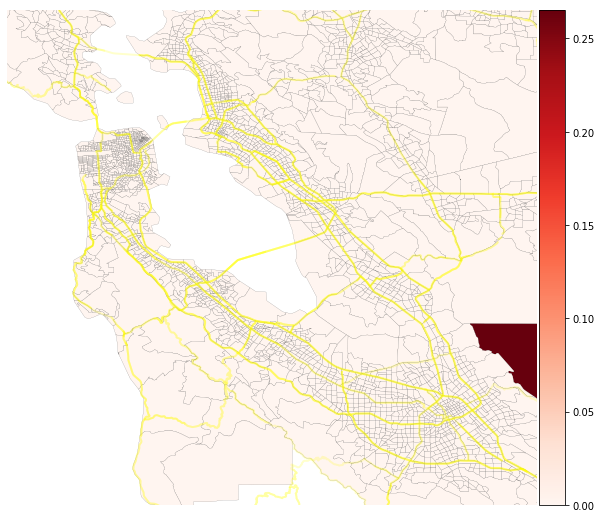

In [67]:
highlight(5681,False)

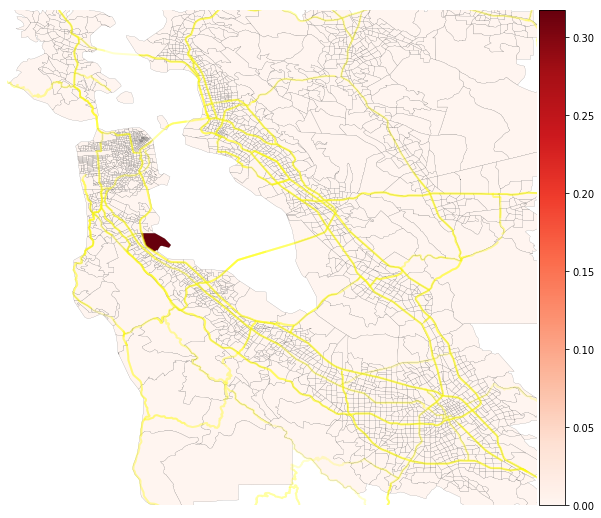

In [59]:
highlight(5135,False)

In [22]:
def highlight(mov_id,zoom=False):
    sfo_taz['highlight'] = 0
    
    sfo_taz.loc[sfo_taz.MOVEMENT_ID == str(mov_id),['highlight']] = 0
    
        
    vmin, vmax = 0, 1
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)

    ax = sfo_taz.plot(figsize=(10,10),column='highlight',cmap='Reds',zorder=1,edgecolor='black',linewidth=0.05,categorical=True)
    #plt.title(date) #date
    ax.axis('off')
    if zoom==False:
        plt.xlim(west,east)
        plt.ylim(south,north)
    else:
        westlimit=-122.521907; southlimit=37.680985; eastlimit=-122.320377; northlimit=37.832718
        plt.xlim(westlimit,eastlimit)
        plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    
#     roads.plot(ax=ax,color='yellow',alpha=0.2,edgecolor='blue', linewidth=2,zorder=2)
#     #ADD ROADS LAYER
#     #edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="blue")

#     #PLACE COLORBAR
#     fig = ax.get_figure()
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.025)
#     sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     # fake up the array of the scalar mappable.
#     sm._A = []

#     cbar = fig.colorbar(sm, cax=cax)
    
    plt.savefig("PROCESSED_SFO.pdf", dpi=1000)
    

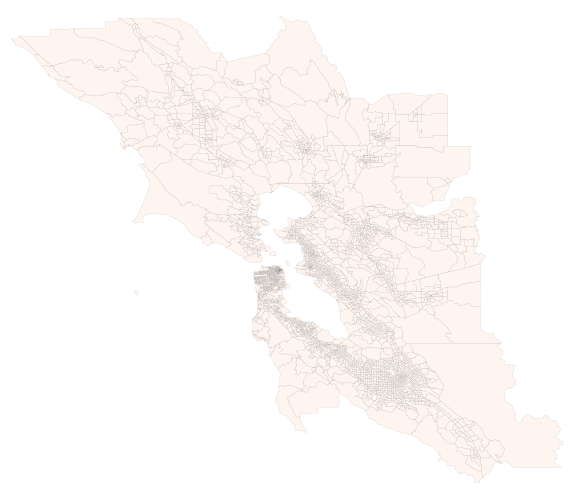

In [23]:
highlight(1)

In [ ]:
plt.figure(figsize=(8,8))
for city in ['BOSTON','M]
    for kind in ['in','out']:
        for hour in [4,18]:
            cents = []
            cluster_sizes = []
            num_clusters=[]
            with open('{}_cluster_analysis_BOSTON_hour_{}.txt'.format(kind,hour)) as f:
                for line in f:
                    line = line.replace(',','')
                    values = line[1:-2].split()

                    cents.append(float(values[0]))
                    cluster_sizes.append(float(values[1]))
                    num_clusters.append(float(values[2]))